<a href="https://colab.research.google.com/github/shahnewaz007/SoftComp/blob/main/170104103_exp_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



> Notebook Prepared by: Ayon


> Course Teacher: Sanzana Karim Lora





## NumtaDB: Bengali Handwritten Digits (Neural Network)

## Six Layer FNN with ReLU Activation

- **Input dimension:**
  - Size of image: $28 \times 28 = 784$

- **Output dimension: 10**
  - 0, 1, 2, 3, 4, 5, 6, 7, 8, 9

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

root_path = '/content/drive/MyDrive/SoftComp/Assignment_2/'

Mounted at /content/drive


### Import Library

In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
from PIL import Image
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [ ]:
# Hyperparameters

batch_size = 20
num_iters = 20000
input_dim = 28*28 # num_features = 784
num_hidden = 200 # num of hidden nodes
output_dim = 10

learning_rate = 0.01  # More power so we can learn faster! previously it was 0.001

startingEpoch = 0
iteration_loss = []
iter = 0
load_model = os.path.isfile(root_path + 'Experiment1_Checkpoint1.pth.tar')

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Confusion Matrix

In [ ]:
def plot_confusion_matrix(cm, classes):
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title('Confusion matrix')
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  thresh = cm.max() / 2.
  for i in range (cm.shape[0]):
    for j in range (cm.shape[1]):
      plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
      plt.tight_layout()
      plt.ylabel('True label')
      plt.xlabel('Predicted label')

### Loading NumtaDB Dataset

In [ ]:
df = pd.read_csv(root_path + 'Dataset C/training-c.csv')

In [ ]:
df = df[['filename', 'digit']]

In [ ]:
class NumtaDBDataset(Dataset):
  def __init__(self, df, root, transform):
    self.data = df
    self.root = root
    self.transform = transform
        
  def __len__(self):
    return len(self.data)
    
  def __getitem__(self, index):
    item = self.data.iloc[index]
    
    path = self.root + "/" + item[0]
    image = Image.open(path).convert('L')
    label = item[1]
    image = self.transform(image)
        
    return image, label

In [ ]:
dataset_transform = transforms.Compose([
  transforms.Resize(28),
  transforms.ToTensor(),                                                                                                                                                                                                                                                                                                                                                                                                                         
  transforms.Normalize((0.5,), (0.5,))
])

data  = NumtaDBDataset(df, root_path + 'Dataset C/training-c', dataset_transform)

print("Training Samples: ",len(data))

Training Samples:  24298


In [ ]:
# split data 20% for testing
test_size = 0.2

# obtain training indices that will be used for validation
num_train = len(data)

# mix data
# index of num of train
indices = list(range(num_train))
# random the index
np.random.seed(42)
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
# divied into two part
train_idx, test_idx = indices[split:], indices[:split]

# define the sampler
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

num_epochs = num_iters / (len(train_idx) / batch_size)
num_epochs = int(num_epochs)

# prepare loaders
train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(data, batch_size=batch_size,sampler=test_sampler)

<div align="center">
<img src="https://drive.google.com/uc?id=1mn8G92moF0MqXhD0J-M7cPidCYXR0hHS" width="680" height="380">
</div>



### Step #1 : Design model using class

In [ ]:
class DeepNeuralNetworkModel(nn.Module):
  def __init__(self, input_size, num_classes, num_hidden):
    super().__init__()
    ### 1st hidden layer: 784 --> 200
    self.linear_1 = nn.Linear(input_size, num_hidden)
    ### Non-linearity in 1st hidden layer
    self.relu_1 = nn.ReLU()

    ### 2nd hidden layer: 200 --> 200
    self.linear_2 = nn.Linear(num_hidden, num_hidden)
    ### Non-linearity in 2nd hidden layer
    self.relu_2 = nn.ReLU()

    ### 3rd hidden layer: 200 --> 200
    self.linear_3 = nn.Linear(num_hidden, num_hidden)
    ### Non-linearity in 3rd hidden layer
    self.relu_3 = nn.ReLU()

    ### 4th hidden layer: 200 --> 200
    self.linear_4 = nn.Linear(num_hidden, num_hidden)
    ### Non-linearity in 4th hidden layer
    self.relu_4 = nn.ReLU()

    ### 5th hidden layer: 200 --> 200
    self.linear_5 = nn.Linear(num_hidden, num_hidden)
    ### Non-linearity in 5th hidden layer
    self.relu_5 = nn.ReLU()

    ### 6th hidden layer: 200 --> 200
    self.linear_6 = nn.Linear(num_hidden, num_hidden)
    ### Non-linearity in 6th hidden layer
    self.relu_6 = nn.ReLU()

    ### Output layer: 200 --> 10
    self.linear_out = nn.Linear(num_hidden, num_classes)   
    
  def forward(self, x):
    ### 1st hidden layer
    out  = self.linear_1(x)
    ### Non-linearity in 1st hidden layer
    out = self.relu_1(out)
        
    ### 2nd hidden layer
    out  = self.linear_2(out)
    ### Non-linearity in 2nd hidden layer
    out = self.relu_2(out)

    ### 3rd hidden layer
    out  = self.linear_3(out)
    ### Non-linearity in 3rd hidden layer
    out = self.relu_3(out)

    ### 4th hidden layer
    out  = self.linear_4(out)
    ### Non-linearity in 4th hidden layer
    out = self.relu_4(out)

    ### 5th hidden layer
    out  = self.linear_5(out)
    ### Non-linearity in 5th hidden layer
    out = self.relu_5(out)

    ### 6th hidden layer
    out  = self.linear_6(out)
    ### Non-linearity in 6th hidden layer
    out = self.relu_6(out)
        
    # Linear layer (output)
    probas  = self.linear_out(out)
    return probas

In [ ]:
'''
INSTANTIATE MODEL CLASS
'''
model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_hidden)
# To enable GPU
model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=784, out_features=200, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=200, out_features=200, bias=True)
  (relu_2): ReLU()
  (linear_3): Linear(in_features=200, out_features=200, bias=True)
  (relu_3): ReLU()
  (linear_4): Linear(in_features=200, out_features=200, bias=True)
  (relu_4): ReLU()
  (linear_5): Linear(in_features=200, out_features=200, bias=True)
  (relu_5): ReLU()
  (linear_6): Linear(in_features=200, out_features=200, bias=True)
  (relu_6): ReLU()
  (linear_out): Linear(in_features=200, out_features=10, bias=True)
)

### Step #2 : Construct loss and optimizer

Unlike linear regression, we do not use MSE here, we need Cross Entropy Loss to calculate our loss before we backpropagate and update our parameters.

`criterion = nn.CrossEntropyLoss() ` 

It does 2 things at the same time.

1. Computes softmax ([Logistic or Sigmoid]/softmax function)
2. Computes Cross Entropy Loss

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

### Step #3 : Training: forward, loss, backward, step

In [ ]:
if load_model:
  checkpoint = torch.load(root_path + 'Experiment1_Checkpoint1.pth.tar')
  print("=> Loading checkpoint")
  print(str(checkpoint['iter'])+' iteration complete so far.')
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  loss = checkpoint['loss']
  startingEpoch = checkpoint['epoch']
  iteration_loss = checkpoint['iteration_loss']
  iter = checkpoint['iter']
  model.train()
print('Starting Epoch '+ str(startingEpoch + 1))
if startingEpoch+1 < num_epochs:
  for epoch in range(startingEpoch, num_epochs):      
    for i, (images, labels) in enumerate(train_loader):
      print('Iteration ' +str(iter) + ' complete')
      images = images.view(-1, 28*28).to(device)
      labels = labels.to(device)

      # Clear gradients w.r.t. parameters
      optimizer.zero_grad()

      # Forward pass to get output/logits
      outputs = model(images) 

      # Calculate Loss: softmax --> cross entropy loss
      loss = criterion(outputs, labels)

      # Getting gradients w.r.t. parameters
      loss.backward()

      # Updating parameters
      optimizer.step()

      iter += 1

      if iter % 500 == 0:
        # Calculate Accuracy         
        correct = 0
        total = 0
        # Iterate through test dataset
        for images, labels in test_loader:
          
          images = images.view(-1, 28*28).to(device)

          # Forward pass only to get logits/output
          outputs = model(images)

          # Get predictions from the maximum value
          _, predicted = torch.max(outputs, 1)

          # Total number of labels
          total += labels.size(0)


          # Total correct predictions
          if torch.cuda.is_available():
            correct += (predicted.cpu() == labels.cpu()).sum() 
          else:
            correct += (predicted == labels).sum()

        accuracy = 100 * correct.item() / total
        
        # Print Loss
        iteration_loss.append(loss.item())
        print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

    checkpoint = {'epoch': epoch, 
                  'model_state_dict': model.state_dict(), 
                  'optimizer_state_dict': optimizer.state_dict(),
                  'loss': loss,
                  'iteration_loss': iteration_loss,
                  'iter': iter}
    print("=> Saving checkpoint of epoch " + str(epoch))
    torch.save(checkpoint, root_path + 'Experiment1_Checkpoint1.pth.tar')
else:
  print('Training Complete')

=> Loading checkpoint
19440 iteration complete so far.
Starting Epoch 20
Training Complete


### Iteration Vs Loss

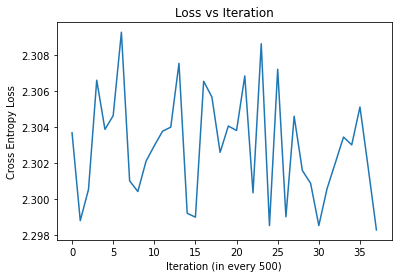

In [ ]:
plt.title("Loss vs Iteration")
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

### Save Model

In [ ]:
save_model = True

if save_model is True:
  # Saves only parameters
  # weights & biases
  torch.save(model.state_dict(), root_path + 'Experiment1_NN1.pkl') 

### Load Model

In [ ]:
load_model = True

if load_model is True:
  model.load_state_dict(torch.load(root_path + 'Experiment1_NN1.pkl'))
  print('Trained Model Loaded')

Trained Model Loaded


In [ ]:
len(test_loader)


243

### Testing NumtaDB Loaded Model

In [ ]:
def get_all_prediction(loader):
  predictions_list = torch.tensor([], dtype=torch.int32)
  labels_list = torch.tensor([], dtype=torch.int32)
  for i, (images, labels) in enumerate(loader):
    images = images.view(-1, 28*28).to(device)
    labels = labels.to(device)

    # Forward pass only to get logits/output
    outputs = model(images)

    # Get predictions from the maximum value
    _, predictions = torch.max(outputs, 1)
    predictions_list = torch.cat((predictions_list, predictions.cpu()), dim = 0)
    labels_list = torch.cat((labels_list.cpu(), labels.cpu()), dim = 0).to(device)
  return predictions_list, labels_list.cpu()

In [ ]:
y_pred, y_true = get_all_prediction(test_loader)

In [ ]:
y_pred

tensor([2, 2, 2,  ..., 2, 2, 2])

In [ ]:
y_true

tensor([0, 8, 2,  ..., 6, 9, 5])

Accuracy: 0.1031
Precision: 0.1031
Recall: 0.1031
F1 score: 0.1031


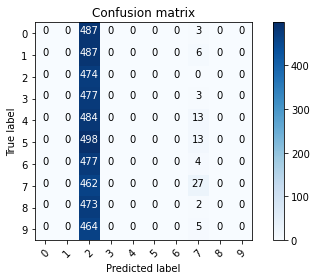

In [ ]:
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred)
# plot the confusion matrix
print('Accuracy: ' +str(round(accuracy_score(y_true, y_pred), 4)))
print('Precision: ' +str(round(precision_score(y_true, y_pred, average='micro'), 4)))
print('Recall: ' +str(round(recall_score(y_true, y_pred, average='micro'), 4)))
print('F1 score: ' +str(round(f1_score(y_true, y_pred, average='micro'), 4)))
plot_confusion_matrix(confusion_mtx, classes = range(10))

## Model Performance Check

## Fashion MNIST (Neural Network)

In [ ]:
# Hyperparameters

batch_size = 20
num_iters = 20000
input_dim = 28*28 # num_features = 784
num_hidden = 200 # num of hidden nodes
output_dim = 10

learning_rate = 0.01  # More power so we can learn faster! previously it was 0.001

startingEpoch = 0
iteration_loss = []
iter = 0
load_model = os.path.isfile(root_path + 'Experiment1_Checkpoint2.pth.tar')

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Loading Fashion MNIST Dataset 

In [ ]:
train_dataset = pd.read_csv(root_path + "Dataset_2/verification_train.csv")
test_dataset = pd.read_csv(root_path + "Dataset_2/verification_test.csv")

In [ ]:
print(len(train_dataset))
print(len(test_dataset))

60000
10000


In [ ]:
X_data = train_dataset.drop("label", axis=1).values.astype(np.uint8)
y_data = train_dataset["label"].values.astype(np.uint8)

X_test = test_dataset.drop("label", axis=1).values.astype(np.uint8)
y_test = test_dataset["label"].values.astype(np.uint8)

In [ ]:
class FashionMNISTDataset(Dataset):
  def __init__(self, X, y, transforms):
    self.X = X
    self.y = y
    self.transforms = transforms

  def __len__(self):
    return self.X.shape[0]

  def __getitem__(self, idx):
    X = np.reshape(self.X[idx], (28, 28, 1))
    X = self.transforms(X)
    return X, self.y[idx]

In [ ]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [ ]:
train_dataset = FashionMNISTDataset(X=X_data, y=y_data, transforms=transform_test)
test_dataset = FashionMNISTDataset(X=X_test, y=y_test, transforms=transform_test)

num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

# prepare loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)   # It's better to shuffle the whole training dataset! 

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False) 

<div align="center">
<img src="https://drive.google.com/uc?id=1mn8G92moF0MqXhD0J-M7cPidCYXR0hHS" width="680" height="380">
</div>



### Step #1 : Design model using class

In [ ]:
class DeepNeuralNetworkModel(nn.Module):
  def __init__(self, input_size, num_classes, num_hidden):
    super().__init__()
    ### 1st hidden layer: 784 --> 200
    self.linear_1 = nn.Linear(input_size, num_hidden)
    ### Non-linearity in 1st hidden layer
    self.relu_1 = nn.ReLU()

    ### 2nd hidden layer: 200 --> 200
    self.linear_2 = nn.Linear(num_hidden, num_hidden)
    ### Non-linearity in 2nd hidden layer
    self.relu_2 = nn.ReLU()

    ### 3rd hidden layer: 200 --> 200
    self.linear_3 = nn.Linear(num_hidden, num_hidden)
    ### Non-linearity in 3rd hidden layer
    self.relu_3 = nn.ReLU()

    ### 4th hidden layer: 200 --> 200
    self.linear_4 = nn.Linear(num_hidden, num_hidden)
    ### Non-linearity in 4th hidden layer
    self.relu_4 = nn.ReLU()

    ### 5th hidden layer: 200 --> 200
    self.linear_5 = nn.Linear(num_hidden, num_hidden)
    ### Non-linearity in 5th hidden layer
    self.relu_5 = nn.ReLU()

    ### 6th hidden layer: 200 --> 200
    self.linear_6 = nn.Linear(num_hidden, num_hidden)
    ### Non-linearity in 6th hidden layer
    self.relu_6 = nn.ReLU()

    ### Output layer: 200 --> 10
    self.linear_out = nn.Linear(num_hidden, num_classes)   
    
  def forward(self, x):
    ### 1st hidden layer
    out  = self.linear_1(x)
    ### Non-linearity in 1st hidden layer
    out = self.relu_1(out)
        
    ### 2nd hidden layer
    out  = self.linear_2(out)
    ### Non-linearity in 2nd hidden layer
    out = self.relu_2(out)

    ### 3rd hidden layer
    out  = self.linear_3(out)
    ### Non-linearity in 3rd hidden layer
    out = self.relu_3(out)

    ### 4th hidden layer
    out  = self.linear_4(out)
    ### Non-linearity in 4th hidden layer
    out = self.relu_4(out)

    ### 5th hidden layer
    out  = self.linear_5(out)
    ### Non-linearity in 5th hidden layer
    out = self.relu_5(out)

    ### 6th hidden layer
    out  = self.linear_6(out)
    ### Non-linearity in 6th hidden layer
    out = self.relu_6(out)
        
    # Linear layer (output)
    probas  = self.linear_out(out)
    return probas

In [ ]:
'''
INSTANTIATE MODEL CLASS
'''
model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_hidden)
# To enable GPU
model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=784, out_features=200, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=200, out_features=200, bias=True)
  (relu_2): ReLU()
  (linear_3): Linear(in_features=200, out_features=200, bias=True)
  (relu_3): ReLU()
  (linear_4): Linear(in_features=200, out_features=200, bias=True)
  (relu_4): ReLU()
  (linear_5): Linear(in_features=200, out_features=200, bias=True)
  (relu_5): ReLU()
  (linear_6): Linear(in_features=200, out_features=200, bias=True)
  (relu_6): ReLU()
  (linear_out): Linear(in_features=200, out_features=10, bias=True)
)

### Step #2 : Construct loss and optimizer

Unlike linear regression, we do not use MSE here, we need Cross Entropy Loss to calculate our loss before we backpropagate and update our parameters.

`criterion = nn.CrossEntropyLoss() ` 

It does 2 things at the same time.

1. Computes softmax ([Logistic or Sigmoid]/softmax function)
2. Computes Cross Entropy Loss

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

### Step #3 : Training: forward, loss, backward, step

In [ ]:
if load_model:
  checkpoint = torch.load(root_path + 'Experiment1_Checkpoint2.pth.tar')
  print("=> Loading checkpoint")
  print(str(checkpoint['iter'])+' iteration complete so far.')
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  loss = checkpoint['loss']
  startingEpoch = checkpoint['epoch']
  iteration_loss = checkpoint['iteration_loss']
  iter = checkpoint['iter']
  model.train()
if startingEpoch+1 < num_epochs:
  print('Starting Epoch '+ str(startingEpoch + 1))
  for epoch in range(startingEpoch, num_epochs):      
    for i, (images, labels) in enumerate(train_loader):
      if iter % 5 == 0:
        print('Iteration ' +str(iter) + ' complete')
      images = images.view(-1, 28*28).to(device)
      labels = labels.to(device).type(torch.LongTensor)

      # Clear gradients w.r.t. parameters
      optimizer.zero_grad()

      # Forward pass to get output/logits
      outputs = model(images).cpu()

      # Calculate Loss: softmax --> cross entropy loss
      loss = criterion(outputs, labels)

      # Getting gradients w.r.t. parameters
      loss.backward()

      # Updating parameters
      optimizer.step()

      iter += 1

      if iter % 500 == 0:
        # Calculate Accuracy         
        correct = 0
        total = 0
        # Iterate through test dataset
        for images, labels in test_loader:
          
          images = images.view(-1, 28*28).to(device)

          # Forward pass only to get logits/output
          outputs = model(images)

          # Get predictions from the maximum value
          _, predicted = torch.max(outputs, 1)

          # Total number of labels
          total += labels.size(0)


          # Total correct predictions
          if torch.cuda.is_available():
            correct += (predicted.cpu() == labels.cpu()).sum() 
          else:
            correct += (predicted == labels).sum()

        accuracy = 100 * correct.item() / total
        
        # Print Loss
        iteration_loss.append(loss.item())
        print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

    checkpoint = {'epoch': epoch, 
                  'model_state_dict': model.state_dict(), 
                  'optimizer_state_dict': optimizer.state_dict(),
                  'loss': loss,
                  'iteration_loss': iteration_loss,
                  'iter': iter}
    print("=> Saving checkpoint of epoch " + str(epoch))
    torch.save(checkpoint, root_path + 'Experiment1_Checkpoint2.pth.tar')
else:
  print('Training Complete')

Starting Epoch 1
Iteration 0 complete
Iteration 5 complete
Iteration 10 complete
Iteration 15 complete
Iteration 20 complete
Iteration 25 complete
Iteration 30 complete
Iteration 35 complete
Iteration 40 complete
Iteration 45 complete
Iteration 50 complete
Iteration 55 complete
Iteration 60 complete
Iteration 65 complete
Iteration 70 complete
Iteration 75 complete
Iteration 80 complete
Iteration 85 complete
Iteration 90 complete
Iteration 95 complete
Iteration 100 complete
Iteration 105 complete
Iteration 110 complete
Iteration 115 complete
Iteration 120 complete
Iteration 125 complete
Iteration 130 complete
Iteration 135 complete
Iteration 140 complete
Iteration 145 complete
Iteration 150 complete
Iteration 155 complete
Iteration 160 complete
Iteration 165 complete
Iteration 170 complete
Iteration 175 complete
Iteration 180 complete
Iteration 185 complete
Iteration 190 complete
Iteration 195 complete
Iteration 200 complete
Iteration 205 complete
Iteration 210 complete
Iteration 215 co

### Iteration Vs Loss

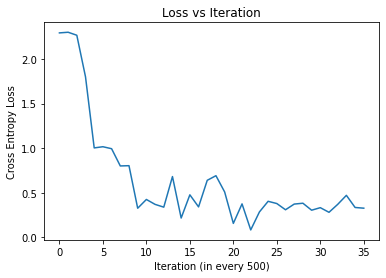

In [ ]:
plt.title("Loss vs Iteration")
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

### Save Model

In [ ]:
save_model = True

if save_model is True:
  # Saves only parameters
  # weights & biases
  torch.save(model.state_dict(), root_path + 'Experiment1_NN2.pkl') 

### Load Model

In [ ]:
load_model = True

if load_model is True:
  model.load_state_dict(torch.load(root_path + 'Experiment1_NN2.pkl'))
  print('Trained Model Loaded')

Trained Model Loaded


### Testing Fashion MNIST Loaded Model

In [ ]:
y_pred, y_true = get_all_prediction(test_loader)

Accuracy: 0.8703
Precision: 0.8703
Recall: 0.8703
F1 score: 0.8703


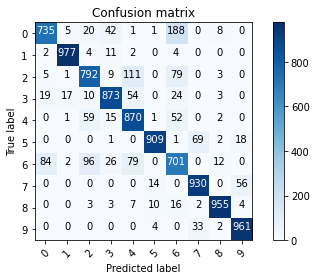

In [ ]:
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred)
# plot the confusion matrix
print('Accuracy: ' +str(round(accuracy_score(y_true, y_pred), 4)))
print('Precision: ' +str(round(precision_score(y_true, y_pred, average='micro'), 4)))
print('Recall: ' +str(round(recall_score(y_true, y_pred, average='micro'), 4)))
print('F1 score: ' +str(round(f1_score(y_true, y_pred, average='micro'), 4)))
plot_confusion_matrix(confusion_mtx, classes = range(10))